In [ ]:
!pip install antigranular


In [62]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Iris Dataset")

Connected to Antigranular server session id: ba2f15d9-122c-4b92-ba35-f047823ee1f9
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


In [64]:
%%ag
from ag_utils import export , load_dataset
import pandas as pd
from op_pandas import PrivateDataFrame


In [65]:
%%ag
x = load_dataset("Iris Dataset")
train_x = x["train_x"]
train_y = x["train_y"]
test_x = x["test_x"]

In [10]:
%%ag
export(train_x.describe(eps=0.1) , 'result')

Total epsilon spent = 0.1000

Setting up exported variable in local environment: result


In [11]:
result

,sepal_length,sepal_width,petal_length,petal_width
count,120.000000,120.000000,120.000000,120.000000
mean,7.900000,4.400000,1.000000,1.492748
std,0.666302,0.455260,1.075637,0.620479
min,7.484444,2.293445,6.257511,0.274017
25%,4.375361,3.759836,6.189582,2.191068
50%,6.248892,2.343492,2.435148,1.146014
75%,7.037398,3.469734,4.369681,1.206054
max,4.337628,3.629162,4.424669,1.606688


In [12]:
%%ag
from typing import Any
# encoding categoricals
def func_(x:str)-> int:
  if x == 'Iris-setosa':
    return 0
  elif x == 'Iris-versicolor':
    return 1
  else: # Iris-virginica
    return 2

train_y_encoded = train_y.applymap(func_ , output_bounds={'species':(0,2)})

In [13]:
%%ag
train_data = train_x.join(train_y_encoded , how="left")
export(train_data.describe(eps=0.5) , 'result')

Total epsilon spent = 0.5000

Setting up exported variable in local environment: result


In [14]:
result

,sepal_length,sepal_width,petal_length,petal_width,species
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,7.900000,2.000000,6.900000,1.341761,0.991667
std,1.141310,0.787163,1.629271,0.204766,0.814736
min,4.366657,4.307830,4.556061,0.541521,0.000000
25%,6.231722,2.857793,5.844202,0.473582,0.000000
50%,4.418679,2.150447,3.830689,1.802737,1.000000
75%,6.384749,4.313818,3.787246,1.219459,2.000000
max,5.268284,2.582134,4.923395,1.344734,2.000000


In [15]:
%%ag
import op_snsql

/usr/local/lib/python3.10/site-packages/opendp/typing.py:28: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: 'bool',  # np.bool_
/usr/local/lib/python3.10/site-packages/opendp/accuracy.py:218: DeprecationWarning: invalid escape sequence '\g'
  """Convert a discrete Laplacian scale into an accuracy estimate (tolerance) at a statistical significance level `alpha`.



In [16]:
%%ag
privacy = op_snsql.Privacy(epsilon=1.0 , delta=0.01)
reader = op_snsql.from_df(df=train_y_encoded, privacy=privacy)

In [17]:
%%ag
# get idea about expected privacy_cost that will be spent.
total_cost = reader.get_privacy_cost([
    "SELECT COUNT(species) as setosa from df.table WHERE species == 0",
    "SELECT COUNT(species) as versicolor from df.table WHERE species == 1",
    "SELECT COUNT(species) as virginica from df.table WHERE species == 2"
    ])
export(str(total_cost) , "total_cost")

Setting up exported variable in local environment: total_cost


In [18]:
total_cost # (epsilon , delta)

'(6.0, 0.03455249500000013)'

In [19]:
%%ag
# execute returns in the following format -> [[column_names] , [values]]
c0 = reader.execute("SELECT COUNT(species) as setosa from df.table WHERE species == 0")
c1 = reader.execute("SELECT COUNT(species) as versicolor from df.table WHERE species == 1")
c2 = reader.execute("SELECT COUNT(species) as virginica from df.table WHERE species == 2")

export(str([c0,c1,c2]) , 'counts')

Setting up exported variable in local environment: counts


In [20]:
count_data = eval(counts)
col , count = [i[0][0] for i in count_data] , [i[1][0] for i in count_data]
print(f"col = {col} , count = {count}")

col = ['setosa', 'versicolor', 'virginica'] , count = [39, 39, 39]


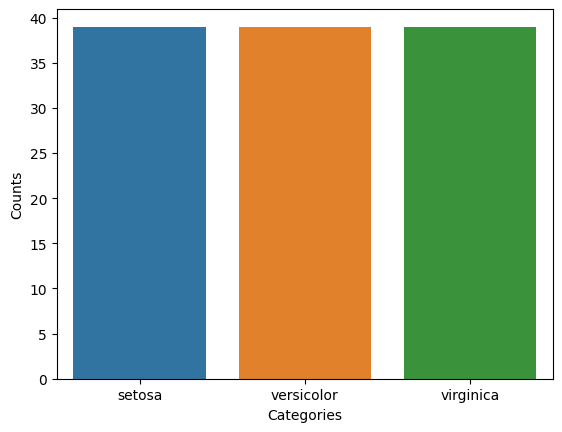

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=col , y=count)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

In [26]:
%%ag
priv_corr = train_x.corr(eps=5)
export(priv_corr , 'priv_corr')

Setting up exported variable in local environment: priv_corr


<Axes: >

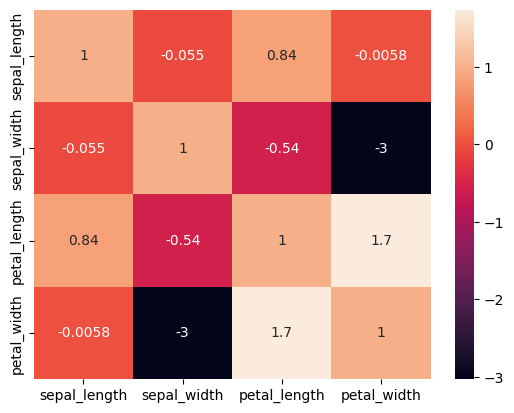

In [27]:
import pandas as pd
result = priv_corr.apply(pd.to_numeric, errors='coerce').astype(float)
sns.heatmap(result , annot = True)

In [56]:
%%ag
from op_diffprivlib.models import RandomForestClassifier
bounds = ( [4.3,2,1,0.1] , [7.9,4.4,6.9,2.5] ) # ([lower] , [upper])
model = RandomForestClassifier(n_estimators=100, epsilon = 1.0 , random_state=0 , bounds=bounds , classes=train_x.columns)

In [57]:
%%ag
model.fit(train_x,train_y)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [58]:
%%ag
Y = model.predict(test_x)
export(Y , "output_y")

Setting up exported variable in local environment: output_y


In [59]:
output_y

array(['petal_length', 'sepal_width', 'sepal_length', 'sepal_length',
       'sepal_length', 'petal_width', 'petal_width', 'sepal_length',
       'sepal_width', 'petal_length', 'sepal_length', 'petal_width',
       'sepal_width', 'petal_width', 'petal_width', 'sepal_length',
       'sepal_length', 'petal_length', 'petal_length', 'sepal_length',
       'petal_width', 'sepal_length', 'petal_width', 'sepal_length',
       'sepal_length', 'sepal_length', 'sepal_length', 'sepal_length',
       'petal_width', 'petal_width'], dtype=object)